In [ ]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.ensemble import RandomForestClassifier

from data_generator import generate_noised_led_sample

In [3]:
warnings.filterwarnings(
    "ignore", message=r"Some inputs do not have OOB scores.*"
)
train_size = 250
flip_proba = 0.2
n_features = 7
n_rep = 100

n_estimators_list = np.logspace(1, 3, num=5, base=10, dtype="int")

rng = np.random.RandomState(0)
X, y = generate_noised_led_sample(
    n_sample=train_size,
    flip_proba=flip_proba,
    random_state=rng,
)

repeated_results_ufi = dict(
    mean=np.zeros((len(n_estimators_list), n_features)),
    low=np.zeros((len(n_estimators_list), n_features)),
    high=np.zeros((len(n_estimators_list), n_features)),
)
repeated_results_mdi_oob = dict(
    mean=np.zeros((len(n_estimators_list), n_features)),
    low=np.zeros((len(n_estimators_list), n_features)),
    high=np.zeros((len(n_estimators_list), n_features)),
)

for i, n_estimators in enumerate(n_estimators_list):
    print(f"Training and computing FIs for {n_estimators} trees, repeated {n_rep} times ...")
    res_ufi = np.zeros((n_rep, n_features))
    res_mdi_oob = np.zeros((n_rep, n_features))
    for rep in range(n_rep):
        rfc = RandomForestClassifier(
            n_estimators=n_estimators,
            oob_score=True,
            n_jobs=-1,
            random_state=rng,
        ).fit(X, y)

        res_ufi[rep, :] = rfc.unbiased_feature_importances_
        res_mdi_oob[rep, :] = rfc._compute_ufi_and_oob_pred(X, y, sample_weight=None, method="MDI_oob")[0]
    
    for feature_idx in range(n_features):
        repeated_results_ufi["mean"][i, feature_idx] = np.mean(res_ufi[:, feature_idx])
        repeated_results_ufi["high"][i, feature_idx], repeated_results_ufi["low"][i, feature_idx] = sp.stats.bootstrap((res_ufi[:, feature_idx],), np.mean).confidence_interval
        repeated_results_mdi_oob["mean"][i, feature_idx] = np.mean(res_mdi_oob[:, feature_idx])
        repeated_results_mdi_oob["high"][i, feature_idx], repeated_results_mdi_oob["low"][i, feature_idx] = sp.stats.bootstrap((res_mdi_oob[:, feature_idx],), np.mean).confidence_interval


Training and computing FIs for 10 trees, repeated 100 times ...
Training and computing FIs for 31 trees, repeated 100 times ...
Training and computing FIs for 100 trees, repeated 100 times ...
Training and computing FIs for 316 trees, repeated 100 times ...
Training and computing FIs for 1000 trees, repeated 100 times ...


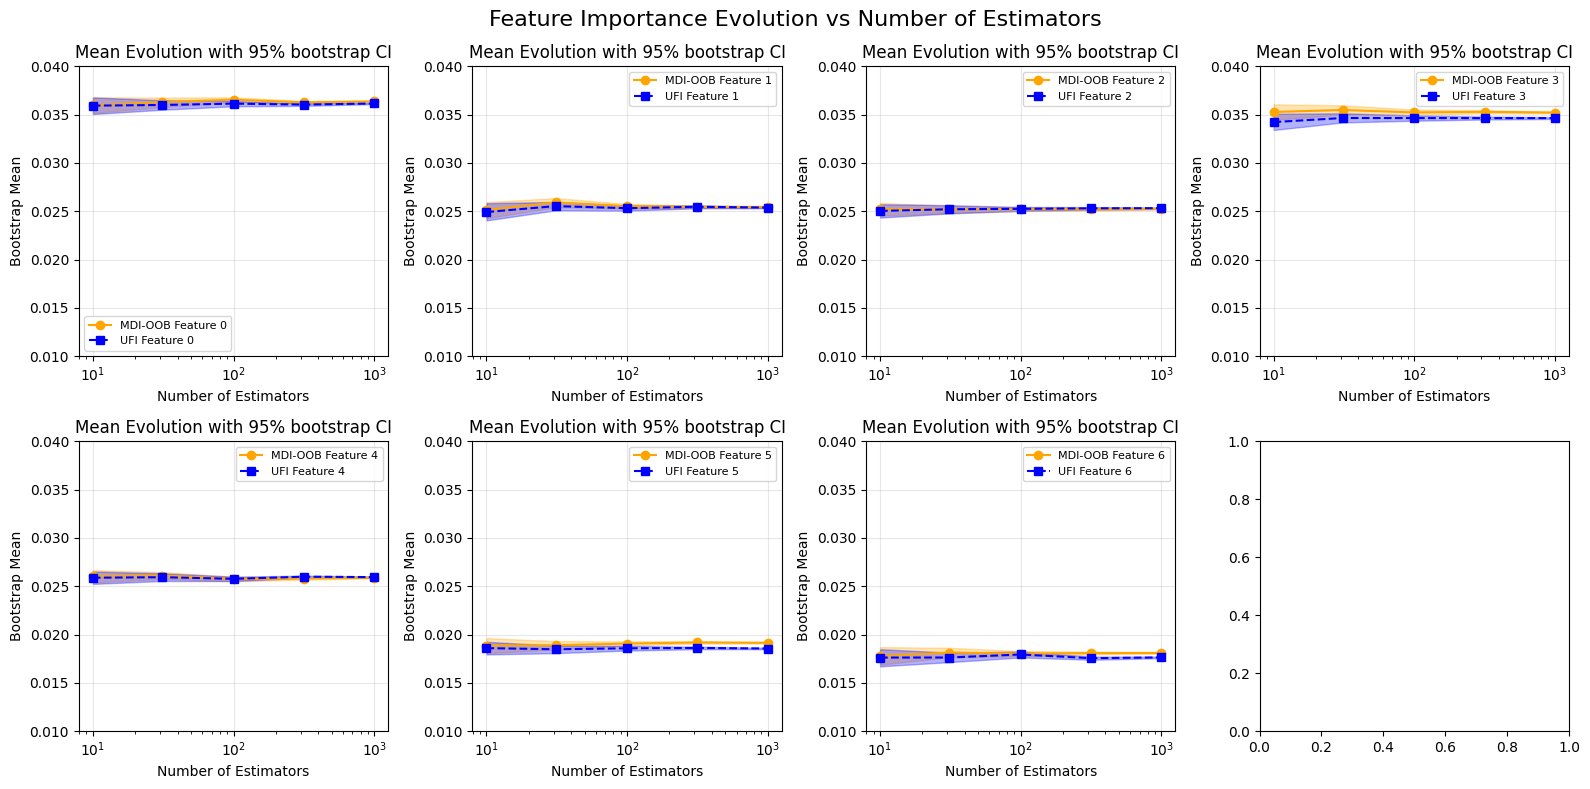

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Feature Importance Evolution vs Number of Estimators", fontsize=16)
axes = axes.flatten()
for feature_idx in range(n_features):
    ax = axes[feature_idx]
    # MDI-OOB
    ax.plot(
        n_estimators_list,
        repeated_results_mdi_oob["mean"][:, feature_idx],
        "o-",
        color="orange",
        label=f"MDI-OOB Feature {feature_idx}",
    )
    ax.fill_between(
        n_estimators_list,
        repeated_results_mdi_oob["low"][:, feature_idx],
        repeated_results_mdi_oob["high"][:, feature_idx],
        alpha=0.3,
        color="orange",
    )

    # UFI
    ax.plot(
        n_estimators_list,
        repeated_results_ufi["mean"][:, feature_idx],
        "s--",
        color="blue",
        label=f"UFI Feature {feature_idx}",
    )
    ax.fill_between(
        n_estimators_list,
        repeated_results_ufi["low"][:, feature_idx],
        repeated_results_ufi["high"][:, feature_idx],
        alpha=0.3,
        color="blue",
    )

    ax.set_xlabel("Number of Estimators")
    ax.set_ylabel("Bootstrap Mean")
    ax.set_title("Mean Evolution with 95% bootstrap CI")
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.set_ylim(0.01, 0.04)

fig.tight_layout()